## Машинное обучение 1, ЭФ МГУ

## Семинар 1

In [21]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import pickle

import numpy as np
import pandas as pd
import matplotlib
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

### Problem 10
Сделайте Tf-idf преобразование текстов и примените метод K-NN (с
косинусной метрикой) для классификации текстов. При каком количестве
соседей достигается наибольшее качество на валидации? Как ещё можно
улучшить качество классификации?

In [22]:
from pprint import pprint

In [23]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset = 'all', remove = ('headers', 'footers', 'quotes'))

In [ ]:
data

{'data': ["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
  'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any othe

In [25]:
target2name_mapping = dict(enumerate(data.target_names))
targets = data.target
texts_list = data.data
print(f"#texts: {len(data.data):,}")
pprint(target2name_mapping)

#texts: 18,846
{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}


In [26]:
# example of texts and targets
np.random.seed(3)
random_id = np.random.randint(len(texts_list))
print(f"random_id: {random_id}")
print("text:")
print(texts_list[random_id])
print('\n' + '='*100 + '\n')
print("target:")
print(target2name_mapping[targets[random_id]])

random_id: 5994
text:

[ a lot of religious opinions and quotations from the Bible and from 
many Catholic theologians and Papal Bulls ]

[ which, although introduced with a smiley, was not as funny as it
might have been (notable exception: subject headers such as "ONE'S 
DICK IS ONE'S INSTRUMENT OF REDEMPTION." ]

[ and indeed, the posting seemed to be more a vehicle for the
religious text than for any "literary/moral analysis" ]

I am surprised and saddened. I would expect this kind of behavior
from the Evangelical Born-Again Gospel-Thumping In-Your-Face We're-
The-Only-True-Christian Protestants, but I have always thought 
that Catholics behaved better than this.

Friend Dennis, I urge you to follow the example of your fellow
Catholics, of who I count many dozens as my friends, and practice
your faith through good example and decent living and respect
for the common humanity of others. Please do not stoop to the
level of the E B-A G-T I-Y-F W-T-O-T-C Protestants, who think
that the 

In [27]:
import spacy
#loading the english language small model of spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
print(len(stopwords))
print(stopwords)

326
{'some', 'seems', 'ca', 'nevertheless', 'already', 'among', 'seem', 'latterly', 'else', 'this', 'ten', 'latter', "'ve", 'will', 'never', 'along', 'made', 'such', 'behind', 'everyone', 'out', 'off', 'themselves', 'call', 'could', 'whose', 'indeed', "'m", 'from', 'no', 'four', "'s", 'upon', 'top', 'keep', 'unless', 'in', 'been', 'afterwards', 'however', 'nine', 'cannot', 'as', 'my', 'wherein', 'and', 'always', 'though', 'these', 'you', '’d', 'beforehand', 'him', 'side', 'by', 'which', 'anyone', 'too', 'none', 'say', 'fifty', 'still', 'at', 'sometime', 'namely', 'a', 'formerly', 'empty', 'myself', 'herself', 'nobody', 'neither', 'enough', 'so', 'be', 'for', 'beside', 'due', 'mostly', 'during', 'to', 'anything', 'first', "'re", 'an', 'now', '‘m', "n't", 'eleven', 'yourselves', 'see', 'since', 'he', 'what', 'amount', 'further', 'n’t', 'anywhere', 'thus', 'somewhere', '’ve', '‘d', 'move', '‘re', 'really', 'must', 'anyhow', 'not', 'if', 'herein', 'quite', 'rather', 'somehow', 'her', 'woul

In [ ]:
#%%time
#processed_texts_list = []
#for text in tqdm(texts_list):
#    processed_text = [
#        str(token.lemma_).lower() for token in nlp(text)
#        if not token.is_stop
#        and str(token).strip() != ''
#    ]
#    processed_texts_list.append(processed_text)

#Pickling
#with open("processed_texts_list.pkl", "wb") as fp:   
#    pickle.dump(processed_texts_list, fp)

#with open("processed_text.pkl", "wb") as fp:   
#    pickle.dump(processed_text, fp)

In [28]:
# Unpickling
with open("processed_texts_list.pkl", "rb") as fp:   
    processed_texts_list = pickle.load(fp)

with open("processed_text.pkl", "rb") as fp:   
    processed_text = pickle.load(fp)

In [29]:
processed_texts_list[1][0:10]

['brother',
 'market',
 'high',
 '-',
 'performance',
 'video',
 'card',
 'support',
 'vesa',
 'local']

In [30]:
processed_text[0:10]

['tip',
 'gary',
 'crum',
 '(',
 'crum@fcom.cc.utah.edu',
 ')',
 'get',
 'phone',
 '"',
 'pontiac']

In [31]:
help(np.array_split)

Help on _ArrayFunctionDispatcher in module numpy:

array_split(ary, indices_or_sections, axis=0)
    Split an array into multiple sub-arrays.
    
    Please refer to the ``split`` documentation.  The only difference
    between these functions is that ``array_split`` allows
    `indices_or_sections` to be an integer that does *not* equally
    divide the axis. For an array of length l that should be split
    into n sections, it returns l % n sub-arrays of size l//n + 1
    and the rest of size l//n.
    
    See Also
    --------
    split : Split array into multiple sub-arrays of equal size.
    
    Examples
    --------
    >>> x = np.arange(8.0)
    >>> np.array_split(x, 3)
    [array([0.,  1.,  2.]), array([3.,  4.,  5.]), array([6.,  7.])]
    
    >>> x = np.arange(9)
    >>> np.array_split(x, 4)
    [array([0, 1, 2]), array([3, 4]), array([5, 6]), array([7, 8])]



In [32]:
# splitting texts into train and test parts
np.random.seed(42)
tr_idxs, te_idxs = np.array_split(
    np.random.permutation(np.arange(len(processed_texts_list))),
    indices_or_sections=[int(len(processed_texts_list)*0.65)]
)
print(f"tr_idxs: {len(tr_idxs):,}")
print(f"te_idxs: {len(te_idxs):,}")

tr_targets = targets[tr_idxs]
te_targets = targets[te_idxs]

tr_idxs: 12,249
te_idxs: 6,597


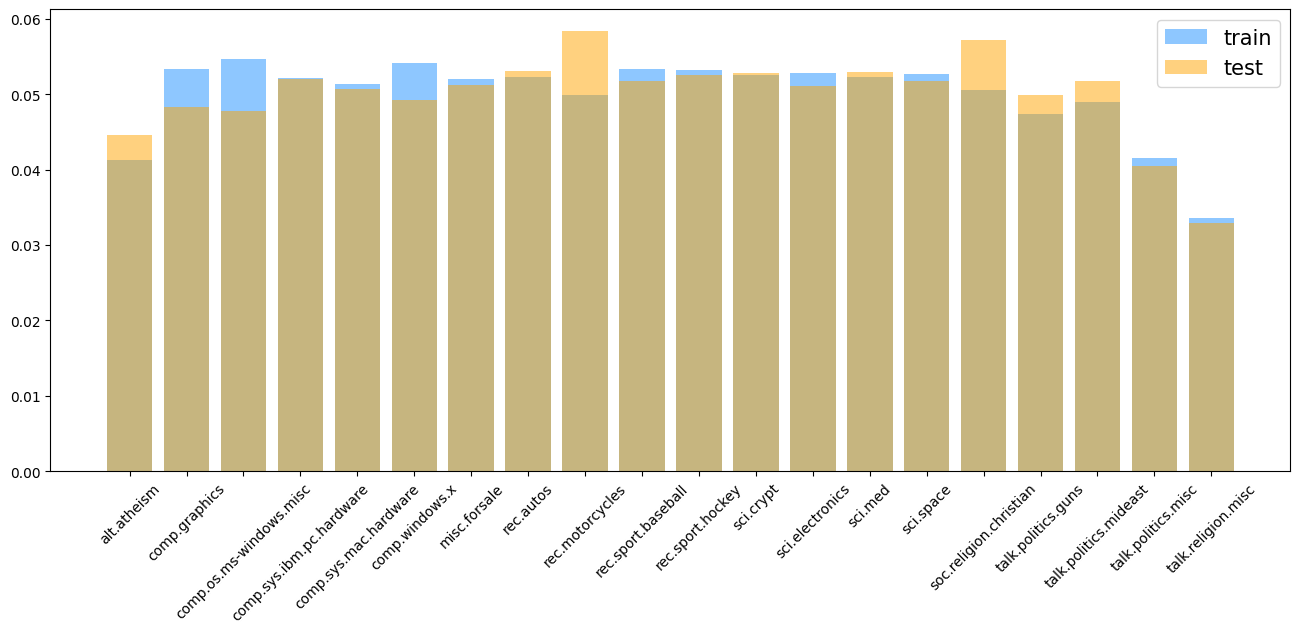

In [33]:
# target distributions viz
tmp_df1 = pd.DataFrame(np.unique(tr_targets, return_counts=True)).T
tmp_df1.columns = ['classes', 'counts_tr']
tmp_df2 = pd.DataFrame(np.unique(te_targets, return_counts=True)).T
tmp_df2.columns = ['classes', 'counts_te']
tmp_df = (
    tmp_df1
    .merge(
        tmp_df2,
        on=['classes'],
        how='outer'
    )
    .fillna(0)
)

plt.figure(figsize=(16, 6))
plt.bar(
    [target2name_mapping[class_] for class_ in tmp_df['classes']],
    tmp_df['counts_tr']/tmp_df['counts_tr'].sum(), color='dodgerblue', label='train',
    alpha = 0.5,
);
plt.bar(
    [target2name_mapping[class_] for class_ in tmp_df['classes']],
    tmp_df['counts_te']/tmp_df['counts_te'].sum(), color='orange', label='test',
    alpha = 0.5,
);
#plt.xticks(tr_classes)
plt.tick_params(axis = 'x', rotation = 45);
plt.legend(fontsize = 15);

In [ ]:
# json.dump(
#     processed_texts_list,
#     open('/content/drive/MyDrive/tmp/processed_texts_list.json', mode='w', encoding='utf-8'),
#     ensure_ascii=False,
#     indent=2
# )
# processed_texts_list = json.load(
#     open('/content/drive/MyDrive/tmp/processed_texts_list.json', mode='r', encoding='utf-8')
# )
# print(len(processed_texts_list))

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [35]:
%%time
tf_idf = TfidfVectorizer(
    analyzer = 'word',
    ngram_range = (1, 3),
    max_df = 0.98,
    min_df = 4,
    max_features = 20_000
)

CPU times: user 59 µs, sys: 1e+03 ns, total: 60 µs
Wall time: 64.1 µs


In [36]:
tf_idf.fit([' '.join(text) for text in np.array(processed_texts_list, dtype = object)[tr_idxs]])

TfidfVectorizer(max_df=0.98, max_features=20000, min_df=4, ngram_range=(1, 3))

In [37]:
X_tr = tf_idf.transform([' '.join(text) for text in np.array(processed_texts_list, dtype = object)[tr_idxs]])
X_te = tf_idf.transform([' '.join(text) for text in np.array(processed_texts_list, dtype = object)[te_idxs]])
print(f"X_tr: {X_tr.shape[0]:,} x {X_tr.shape[1]:,}")
print(f"X_te: {X_te.shape[0]:,} x {X_te.shape[1]:,}")

X_tr: 12,249 x 20,000
X_te: 6,597 x 20,000


In [38]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

In [39]:
%%time
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_tr, tr_targets)

CPU times: user 4.65 ms, sys: 3.58 ms, total: 8.23 ms
Wall time: 8.59 ms


KNeighborsClassifier(n_neighbors=1)

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
train_accuracy = accuracy_score(
    y_true = tr_targets,
    y_pred = model.predict(X_tr)
)
test_accuracy = accuracy_score(
    y_true = te_targets,
    y_pred = model.predict(X_te)
)
print(f"train_accuracy: {round(train_accuracy, 4)}")
print(f"test_accuracy: {round(test_accuracy, 4)}")

train_accuracy: 0.9704
test_accuracy: 0.1924


In [42]:
from sklearn.model_selection import cross_val_score, KFold

In [43]:
param_name = 'n_neighbors'
param_vals = [1, 3, 5, 7, 9, 10, 11, 12, 15, 20, 21, 30, 50, 100]
metric_vals = []
for param in tqdm(param_vals):
    curr_model = KNeighborsClassifier(**{param_name: param})
    folds_scores = cross_val_score(
        estimator=curr_model,
        X=X_tr,
        y=tr_targets,
        groups=None,
        scoring='accuracy',
        cv=KFold(n_splits=5),
        n_jobs=-1,
        verbose=0
    )
    metric_vals.append(folds_scores)
    print(f'param: {param}\tmean accuracy: {round(np.mean(folds_scores), 4)}')

  0%|          | 0/14 [00:00<?, ?it/s]

param: 1	mean accuracy: 0.1727
param: 3	mean accuracy: 0.1476
param: 5	mean accuracy: 0.115
param: 7	mean accuracy: 0.1059
param: 9	mean accuracy: 0.1005
param: 10	mean accuracy: 0.0988
param: 11	mean accuracy: 0.0977
param: 12	mean accuracy: 0.0962
param: 15	mean accuracy: 0.0909
param: 20	mean accuracy: 0.0877
param: 21	mean accuracy: 0.0856
param: 30	mean accuracy: 0.0807
param: 50	mean accuracy: 0.0715
param: 100	mean accuracy: 0.0636


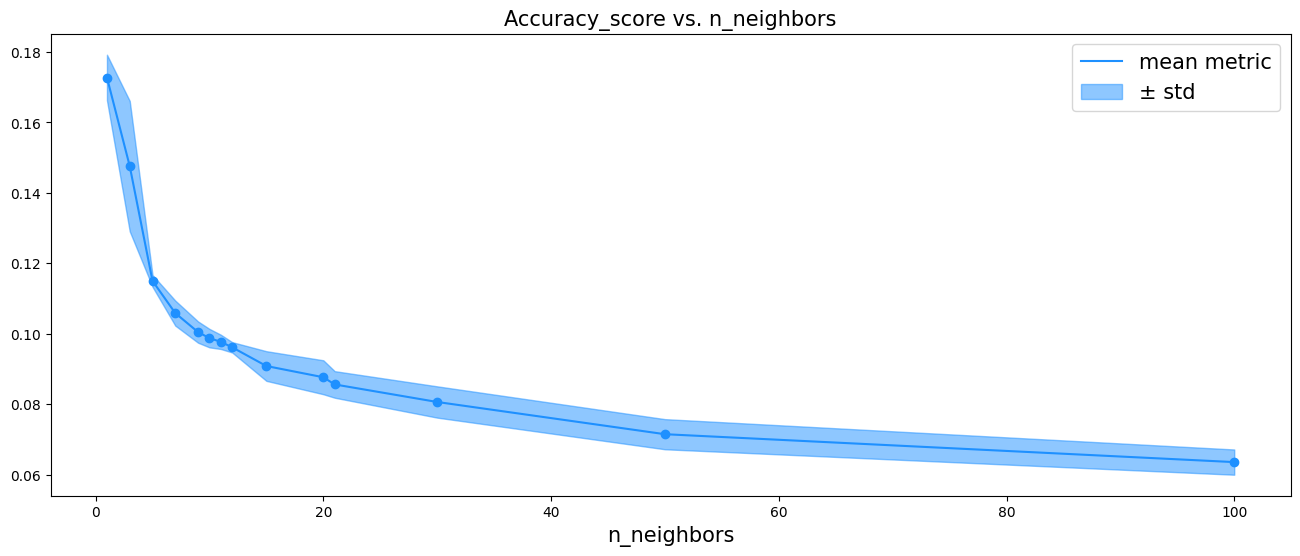

In [44]:
mean_metric = np.array([np.mean(fold_vals) for fold_vals in metric_vals])
std_metric = np.array([np.std(fold_vals) for fold_vals in metric_vals])


plt.figure(figsize=(16, 6))
plt.title(f'Accuracy_score vs. {param_name}', fontsize=15);
plt.plot(param_vals, mean_metric, color='dodgerblue', label='mean metric');
plt.scatter(param_vals, mean_metric, color='dodgerblue');
plt.fill_between(param_vals, mean_metric - std_metric, mean_metric + std_metric, color='dodgerblue', alpha=0.5,
                 label='± std');
plt.xlabel(param_name, fontsize=15);
plt.legend(fontsize=15);

In [ ]:
%%time
# searching neighbors 'by hands'
from scipy.spatial.distance import cdist
eucl_dist_matr = cdist(XA = X_tr.toarray(), XB = X_te.toarray(), metric = 'euclidean')
cosine_dist_matr = cdist(XA = X_tr.toarray(), XB = X_te.toarray(), metric = 'cosine')

# eucl_argdist = eucl_dist_matr.argsort(axis=1)
# cosine_argdist = cosine_dist_matr.argsort(axis=1)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
%%time
sparce_eucl_dist = pairwise_distances(X = X_tr, Y = X_te, metric = 'euclidean')

kNN (пример работы алгоритма): https://yastatic.net/s3/academy/ml/knn_clf/knn_clf.html

## Работа с табличными данными

В машинном обучении, как правило, всё сводится к анализу табличных данных. Начинать мы можем с большого количества сложных таблиц, изображений, текстов или ещё чего-то непростого, но в итоге всё это обычно сводится к одной таблице, где каждый объект описывается набором признаков. Поэтому важно уметь работать с таблицами.

А ещё есть некоторые исследования, показывающие, что в решении задачи интеллектуального анализа данных обычно 20% времени уходит на построение моделей и прочую интересную работу, связанную с тем, что рассказывается у нас на лекциях, а 80% времени специалисты тратят на подготовку и обработку данных. Сюда входит формирование признаков, устранение выбросов и пропусков и т.д. И это тоже, по сути дела, манипуляции с таблицами.

Вывод: важно уметь работать с табличными данными. В Python для этого есть библиотека pandas, которую мы и будем сегодня изучать.

Чаще всего название библиотеки при импорте сокращают до "pd":

In [3]:
import pandas as pd

### Распределение студентов по элективам

Разумно тренироваться на реальных сложных данных. А что может быть более сложным, чем данные, сгенерированные студентами?

Сегодня мы будем работать с анкетами студентов ПМИ 2017 и 2018 годов набора о том, на какие курсы по выбору они хотят попасть. Данные были анонимизированы: ФИО захешированы с солью, к рейтингам добавлен случайный шум.

*Вопрос: как можно деанонимизировать данные после манипуляций, которые мы проделали? А как бы вы предложили провести анонимизацию?*

У нас есть 2 таблицы (для 3 и 4 курса):

    – 'Timestamp': время получения ответов
    – 'ID': ID студента (может повторяться, если студент больше одного раза заполнял анкету) 
    – 'Рейтинг': Кредитно-рейтинговая сумма студента (грубо говоря, сумма оценок студента по всем его дисциплинам с весами — чем дольша шла дисциплина, тем больше вес; подробности тут: https://www.hse.ru/studyspravka/rate/)
    – 'Группа (в формате 182)': Номер группы
    – 'МИ?': 1, если студент распределился на специализацию МИ, или NaN в противном случае (признак важен, поскольку студенты МИ берут осенью два курса по выбору, а студенты остальных специализаций только один)
    – 'Осенний курс по выбору, приоритет 1'
    – 'Осенний курс по выбору, приоритет 2' 
    – 'Осенний курс по выбору, приоритет 3'
    – 'Весенний курс по выбору, приоритет 1'
    – 'Весенний курс по выбору, приоритет 2'
    – 'Весенний курс по выбору, приоритет 3'
    – 'Вы заполняете анкету в первый раз?': "Да" или "Нет"
   
Дополнительные столбцы для 4ого курса:
    
    – 'Группа (в формате 173)': Номер группы
    – 'blended-курс': Выбор blended-курса (кол-во мест неограничено)

Загрузим данные (обратите внимание, что мы легко читаем xlsx-файлы):

In [4]:
!wget  -O 'data_3_course.xlsx' -q 'https://www.dropbox.com/s/ysxs5srafoyxknb/_data_3_course.xlsx?dl=1'
!wget  -O 'data_4_course.xlsx' -q 'https://www.dropbox.com/s/hfg2mzmvcivtxqk/_data_4_course.xlsx?dl=1'

In [5]:
data3 = pd.read_excel('./data_3_course.xlsx')
data4 = pd.read_excel('./data_4_course.xlsx')

Посмотрим размер таблицы:

In [6]:
data3.shape

(223, 12)

Для начала будем работать с одной таблицей для 3 курса. Теперь данные хранятся в переменной ```data3```, которая имеет тип [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html):

In [7]:
type(data3)

pandas.core.frame.DataFrame

DataFrame можно создать и вручную:

In [8]:
df = pd.DataFrame({
    'AAA': [4, 5, 6, 7], 
    'BBB': [10, 20, 30, 40], 
    'CCC': [100, 50, 'E', -50]
})
df

,AAA,BBB,CCC
0,4,10,100
1,5,20,50
2,6,30,E
3,7,40,-50


DataFrame можно частично отобразить в jupyter-ноутбуке с помощью методов ```head```(первые строки) и ```sample```(случайные строки):

In [9]:
data3.head(5)

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,"704,0",181,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,"646,0",181,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,"624,0",185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,"579,0",182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,"632,0",183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да


In [10]:
data3.sample(5)

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
189,2020-05-18 23:30:27.005,7bf79897c5645954846e2e03ec803887,"686,0",186,NaN,Безопасность компьютерных систем,Язык SQL,Сбор и обработка данных с помощью краудсорсинга,Дискретная оптимизация,Компьютерные сети,Промышленное программирование на языке Java,Да
128,2020-05-18 21:12:00.134,be4fa2120de3397ae21eac38ff0060e3,"501,0",187,NaN,Безопасность компьютерных систем,Язык SQL,Матричные вычисления,Промышленное программирование на языке Java,Численные методы,Машинное обучение 2,Да
219,2020-05-20 11:57:07.326,e6f5eb76b34e7ab7bac753e6cb0a2279,"634,0",184,NaN,Теория баз данных,Безопасность компьютерных систем,Моделирование временных рядов,Компьютерные сети,Промышленное программирование на языке Java,Анализ данных в бизнесе,Да
166,2020-05-18 22:15:41.331,b4f1f195bd1bc63490a7bc42275a71cd,"536,0",187,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Компьютерные сети,Промышленное программирование на языке Java,Дискретная оптимизация,Да
222,2020-05-19 04:24:29.000,9d19b0d5f4fc8d7edc2258406f872c4e,"694,0",188,NaN,Безопасность компьютерных систем,Язык SQL,Высокопроизводительные вычисления,Компьютерные сети,Дискретная оптимизация,Численные методы,NaN


Можно немного залезть во внутренности Jupyter, чтобы отобразить сразу несколько таблиц:

In [11]:
from IPython.display import display
display(data3.sample(3)), display(data4.sample(3))

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
5,2020-05-15 09:10:18.558,d0d8ff53ed5b119f9056068e954256c6,"591,0",187,NaN,Язык SQL,Statistical Learning Theory,Сбор и обработка данных с помощью краудсорсинга,Промышленное программирование на языке Java,Численные методы,Дискретная оптимизация,Да
27,2020-05-16 13:02:24.706,5daee1bd98559bb2c52373e416942225,"659,0",182,NaN,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Моделирование временных рядов,Машинное обучение 2,Промышленное программирование на языке Java,Анализ данных в бизнесе,Нет
69,2020-05-18 13:30:49.657,1eafb63c510c305e325bff51d246adb1,"651,0",181,NaN,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Безопасность компьютерных систем,Промышленное программирование на языке Java,Дополнительные главы прикладной статистики,Дискретная оптимизация,Да


,Timestamp,ID,Рейтинг,Группа (в формате 173),blended-курс,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
24,2020-05-16 22:20:51.266,93c0280966ae263fe26c5d78f719f2ae,"1264,0",171,Соревновательный анализ данных,Анализ неструктурированных данных,Байесовские методы машинного обучения,Моделирование временных рядов,Генеративные модели в машинном обучении,Компьютерное зрение,Обучение с подкреплением,Да
92,2020-05-18 21:45:27.359,5ac46b96ef57b09c77dc50a6da3f39a5,"1107,0",174,DevOps,Анализ неструктурированных данных,Глубинное обучение в обработке звука,Моделирование временных рядов,Обучение с подкреплением,Методы сжатия и передачи медиаданных,Компьютерное зрение,Да
137,2020-05-18 23:57:39.000,f2d210ace25a841e1e58036b257d5d47,"1190,0",176,Соревновательный анализ данных,Анализ неструктурированных данных,Моделирование временных рядов,Высокопроизводительные вычисления,Обучение с подкреплением,Компьютерное зрение,Методы сжатия и передачи медиаданных,NaN


(None, None)

Если вам очень хочется отобразить все строки таблицы, то можно сделать так:

In [12]:
pd.options.display.max_rows = 999
data3

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,"704,0",181,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,"646,0",181,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,"624,0",185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,"579,0",182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,"632,0",183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да
5,2020-05-15 09:10:18.558,d0d8ff53ed5b119f9056068e954256c6,"591,0",187,NaN,Язык SQL,Statistical Learning Theory,Сбор и обработка данных с помощью краудсорсинга,Промышленное программирование на языке Java,Численные методы,Дискретная оптимизация,Да
6,2020-05-15 11:42:16.910,e4caca755ee0bdd711e18fb8084958b5,"723,0",181,NaN,Statistical Learning Theory,Безопасность компьютерных систем,Моделирование временных рядов,Численные методы,Промышленное программирование на языке Java,Машинное обучение 2,Да
7,2020-05-15 12:11:43.252,8047c18b3c531c6f47931e0744f3e028,"565,0",187,NaN,Язык SQL,Теория баз данных,Безопасность компьютерных систем,Промышленное программирование на языке Java,Компьютерные сети,Дискретная оптимизация,Да
8,2020-05-15 13:21:40.913,e8b314842f176be9051d14a07cb156cb,"618,0",181,NaN,Язык SQL,Теория баз данных,Матричные вычисления,Промышленное программирование на языке Java,Компьютерные сети,Дискретная оптимизация,Да
9,2020-05-15 13:29:10.789,d6c079f1ff869c8c84fa3ed30bd67e0e,"733,0",181,NaN,Теория баз данных,Высокопроизводительные вычисления,Сбор и обработка данных с помощью краудсорсинга,Дополнительные главы прикладной статистики,Анализ данных в бизнесе,Численные методы,Да


In [13]:
pd.options.display.max_rows = 20

In [14]:
data3

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,"704,0",181,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,"646,0",181,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,"624,0",185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,"579,0",182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,"632,0",183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да
...,...,...,...,...,...,...,...,...,...,...,...,...
218,2020-05-20 11:49:38.801,bd416140ecdb32b6dbd7f40820bf63b1,"517,0",185,NaN,Безопасность компьютерных систем,Теория баз данных,Язык SQL,Машинное обучение 2,Компьютерные сети,Промышленное программирование на языке Java,Да
219,2020-05-20 11:57:07.326,e6f5eb76b34e7ab7bac753e6cb0a2279,"634,0",184,NaN,Теория баз данных,Безопасность компьютерных систем,Моделирование временных рядов,Компьютерные сети,Промышленное программирование на языке Java,Анализ данных в бизнесе,Да
220,2020-05-21 16:33:15.899,1341f488fae5f1ccf164960fd6506cd0,"584,0",188,NaN,Язык SQL,Теория баз данных,Безопасность компьютерных систем,Промышленное программирование на языке Java,Компьютерные сети,Системы баз данных,Да
221,2020-05-24 01:21:31.946,04bcb5c9d23813ffa940e1febb27fadc,"646,0",186,NaN,Теория баз данных,Высокопроизводительные вычисления,Безопасность компьютерных систем,Компьютерные сети,Дискретная оптимизация,Машинное обучение 2,Нет


DataFrame, по сути, является двумерной таблицей с набором полезных методов. Давайте рассмотрим некоторые из них.

```columns``` — возвращает названия колонок

```dtypes``` — типы колонок



In [15]:
data3.columns

Index(['Timestamp', 'ID', 'Рейтинг', 'Группа (в формате 182)', 'МИ?',
       'Осенний курс по выбору, приоритет 1',
       'Осенний курс по выбору, приоритет 2',
       'Осенний курс по выбору, приоритет 3',
       'Весенний курс по выбору, приоритет 1',
       'Весенний курс по выбору, приоритет 2',
       'Весенний курс по выбору, приоритет 3',
       'Вы заполняете анкету в первый раз?'],
      dtype='object')

In [16]:
data3.dtypes

Timestamp                               datetime64[ns]
ID                                              object
Рейтинг                                         object
Группа (в формате 182)                           int64
МИ?                                            float64
Осенний курс по выбору, приоритет 1             object
Осенний курс по выбору, приоритет 2             object
Осенний курс по выбору, приоритет 3             object
Весенний курс по выбору, приоритет 1            object
Весенний курс по выбору, приоритет 2            object
Весенний курс по выбору, приоритет 3            object
Вы заполняете анкету в первый раз?              object
dtype: object

В DataFrame есть несколько способов для обращения к строкам, столбцам и отдельным элементам таблицы: квадратные скобки и методы ```loc```, ```iloc```.

Как обычно, лучший источник знаний об этом — [документация](https://pandas.pydata.org/docs/user_guide/indexing.html).
Ниже краткое содержание.

В метод ```loc``` можно передать значение индекса (число, которое стоит в колонке index) строки, чтобы получить эту строку:

In [17]:
s = pd.Series(list("abcdef"), index=[49, 48, 47, 0, 1, 2])
s

49    a
48    b
47    c
0     d
1     e
2     f
dtype: object

In [18]:
s.loc[0] # value at index label 0 'd' 

'd'

In [19]:
s.iloc[0] # value at index location 0 'a' 

'a'

In [20]:
data3.loc[2]

Timestamp                                     2020-05-15 03:12:41.480000
ID                                      30f3653fc176d54e89ac3179c455c6dd
Рейтинг                                                            624,0
Группа (в формате 182)                                               185
МИ?                                                                  NaN
Осенний курс по выбору, приоритет 1     Безопасность компьютерных систем
Осенний курс по выбору, приоритет 2                 Матричные вычисления
Осенний курс по выбору, приоритет 3        Моделирование временных рядов
Весенний курс по выбору, приоритет 1              Дискретная оптимизация
Весенний курс по выбору, приоритет 2                 Машинное обучение 2
Весенний курс по выбору, приоритет 3                    Численные методы
Вы заполняете анкету в первый раз?                                    Да
Name: 2, dtype: object

Получили отдельную строчку в виде объекта класса [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html):

In [21]:
type(data3.loc[2])

pandas.core.series.Series

А с помощью срезов можно выбрать часть таблицы:

In [22]:
data3.loc[2:4]

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,"624,0",185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,"579,0",182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,"632,0",183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да


Срез в ```loc``` производится по index и включает в себя последний элемент.

Метод ```iloc``` действует похожим образом, но он индексирует элементы не по index, а по порядку в таблице (который может отличаться от index). Например:

In [23]:
subset = data3.sample(5)
subset

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
149,2020-05-18 21:47:05.660,9fa4bc4eb50e574e88b670a86781860b,"603,0",188,NaN,Язык SQL,Высокопроизводительные вычисления,Сбор и обработка данных с помощью краудсорсинга,Промышленное программирование на языке Java,Компьютерные сети,Машинное обучение 2,Нет
41,2020-05-17 01:48:02.632,c97ab5cabace9f00673cc8384771aa9c,"627,0",185,NaN,Безопасность компьютерных систем,Теория баз данных,Язык SQL,Компьютерные сети,Промышленное программирование на языке Java,Машинное обучение 2,Да
184,2020-05-18 23:10:31.329,3d67beeab64f7fe112a8d9e41efbe916,"705,0",183,NaN,Безопасность компьютерных систем,Сбор и обработка данных с помощью краудсорсинга,Язык SQL,Промышленное программирование на языке Java,Компьютерные сети,Дискретная оптимизация,Да
169,2020-05-18 22:24:55.160,f2ed8115db45ef795ced2701fa86515d,"573,0",187,NaN,Безопасность компьютерных систем,Высокопроизводительные вычисления,Statistical Learning Theory,Компьютерные сети,Системы баз данных,Машинное обучение 2,Да
55,2020-05-17 21:26:07.718,48ba69e4b13182a6d89499fd9a2c8f46,"732,0",181,NaN,Матричные вычисления,Теория баз данных,Statistical Learning Theory,Дискретная оптимизация,Промышленное программирование на языке Java,Численные методы,Да


Если же вызвать просто ```loc[2]```, то получим ошибку:


In [24]:
subset.loc[2]

KeyError: 2

С помощью ```iloc``` тоже можно делать срезы, но в них последний элемент не включается (как и в обычных срезах в Python, **в отличие от loc**):

In [ ]:
subset.iloc[2:4]

Срезы можно брать не только по строкам, но и по столбцам. Обратите внимание на различия индексации столбцов в ```loc``` и ```iloc```:

In [ ]:
data3.iloc[2:4, :]

In [25]:
data3.iloc[2:4, 2:6]

,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1"
2,"624,0",185,NaN,Безопасность компьютерных систем
3,"579,0",182,NaN,Statistical Learning Theory


In [26]:
data3.loc[2:4, 'Рейтинг':'Осенний курс по выбору, приоритет 1']

,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1"
2,"624,0",185,NaN,Безопасность компьютерных систем
3,"579,0",182,NaN,Statistical Learning Theory
4,"632,0",183,NaN,Высокопроизводительные вычисления


Через квадратные скобки можно обращаться к одной или нескольким колонкам:

In [27]:
data3[['Рейтинг', 'Осенний курс по выбору, приоритет 1']].head(3)

,Рейтинг,"Осенний курс по выбору, приоритет 1"
0,"704,0",Язык SQL
1,"646,0",Высокопроизводительные вычисления
2,"624,0",Безопасность компьютерных систем


Есть и более интересные способы индексации. Например, давайте выберем студентов из группы 182:

In [28]:
data3[data3['Группа (в формате 182)'] == 182].sample(3)

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
68,2020-05-18 12:55:36.645,d61cc836b6aa3cdc4a40e2e8ada0b937,"671,0",182,NaN,Безопасность компьютерных систем,Высокопроизводительные вычисления,Язык SQL,Компьютерные сети,Промышленное программирование на языке Java,Машинное обучение 2,Нет
183,2020-05-18 23:10:18.303,8a1162ce3c94d8974210a24f4b4f5f74,"710,0",182,NaN,Сбор и обработка данных с помощью краудсорсинга,Язык SQL,Безопасность компьютерных систем,Промышленное программирование на языке Java,Дополнительные главы прикладной статистики,Анализ данных в бизнесе,Да
26,2020-05-15 22:59:40.602,a0c56e8aa03ea6c1f5e8462914472075,"750,0",182,NaN,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Моделирование временных рядов,Дополнительные главы прикладной статистики,Дискретная оптимизация,Численные методы,Да


С DataFrame'ами и Series'ами одинаковой структуры можно производить математические операции:

In [29]:
strange_feature = data3['Рейтинг'] ** 2 + data3['Группа (в формате 182)']
strange_feature.head()

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

Видимо, 'Рейтинг' представлен в виде строки. Исправим это:

In [30]:
data3['Рейтинг'].apply(lambda x: float(str(x).replace(',', '.')))

strange_feature = data3['Рейтинг'] ** 2 + data3['Группа (в формате 182)']
strange_feature.head()

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

Получаем ту же ошибку, ведь метод apply не модифицирует таблицу, а просто возвращает новый столбец. Обходят это обычно так:

In [31]:
data3['Рейтинг'] = data3['Рейтинг'].apply(lambda x: float(x.replace(',', '.')))

In [32]:
strange_feature = data3['Рейтинг'] ** 2 + data3['Группа (в формате 182)']
strange_feature.head()

0    495797.0
1    417497.0
2    389561.0
3    335423.0
4    399607.0
dtype: float64

В дальнейшем нам понадобится работать с перцентилями студентов. Чтобы сделать такой столбец, в pandas уже есть подходящий метод:

In [33]:
data3['percentile'] = 1 - data3['Рейтинг'].rank() / data3.shape[0]

# добавим также наш странный признак
data3['new'] = strange_feature

При желании можно удалить любой признак при помоши метода ```drop```:

In [34]:
data3 = data3.drop(columns=['new'])
data3.head()

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?,percentile
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,704.0,181,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.179372
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,646.0,181,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет,0.504484
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624.0,185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да,0.679372
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579.0,182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.876682
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,632.0,183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да,0.598655


### Разведочный анализ

Теперь изучим наши данные. Вашим домашним заданием будет распределение студентов по курсам, с учётом их предпочтений, рейтинга и ограничений. Начнём к этому готовиться.

Для начала посмотрим еще раз на типы данных и подумаем, надо ли их менять:

In [35]:
data3.dtypes

Timestamp                               datetime64[ns]
ID                                              object
Рейтинг                                        float64
Группа (в формате 182)                           int64
МИ?                                            float64
Осенний курс по выбору, приоритет 1             object
Осенний курс по выбору, приоритет 2             object
Осенний курс по выбору, приоритет 3             object
Весенний курс по выбору, приоритет 1            object
Весенний курс по выбору, приоритет 2            object
Весенний курс по выбору, приоритет 3            object
Вы заполняете анкету в первый раз?              object
percentile                                     float64
dtype: object

Вроде бы нет... 

А что с таблицей для 4ого курса? Как вы знаете, на ряд курсов студенты 3 и 4 годов обучения отбираются совместно, поэтому надо собрать данные в одну таблицу. *Можно ли это сделать без подготовки?*

In [36]:
data3.head()

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?,percentile
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,704.0,181,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.179372
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,646.0,181,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет,0.504484
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624.0,185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да,0.679372
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579.0,182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.876682
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,632.0,183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да,0.598655


In [37]:
data4.head()

,Timestamp,ID,Рейтинг,Группа (в формате 173),blended-курс,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
0,2020-05-14 20:23:21.662,d555d2805e1d93d4f023e57dc4c8f403,"995,0",172,DevOps,Безопасность компьютерных систем,Глубинное обучение в обработке звука,Байесовские методы машинного обучения,Компьютерное зрение,Обучение с подкреплением,Проектирование и разработка высоконагруженных ...,Да
1,2020-05-14 20:47:13.833,253bbe1a2021d0404712a1e4acd22939,"1105,0",176,DevOps,Безопасность компьютерных систем,Моделирование временных рядов,Statistical Learning Theory,Проектирование и разработка высоконагруженных ...,Численные методы,Методы сжатия и передачи медиаданных,Да
2,2020-05-14 20:52:42.734,881b1a6fda195b354ae2edb396a69f5d,"1083,0",172,DevOps,Безопасность компьютерных систем,Анализ неструктурированных данных,Глубинное обучение в обработке звука,Компьютерное зрение,Проектирование и разработка высоконагруженных ...,Генеративные модели в машинном обучении,Да
3,2020-05-14 21:03:02.916,5a9b8ac11ad05b39a58b0e04a263bf4c,"1169,0",171,DevOps,Глубинное обучение в обработке звука,Statistical Learning Theory,Сбор и обработка данных с помощью краудсорсинга,Конфликты и кооперация,Обучение с подкреплением,Генеративные модели в машинном обучении,Да
4,2020-05-14 21:10:54.945,1bbbfae51794b83c769b634be8da7b8d,"1077,0",176,DevOps,Безопасность компьютерных систем,Высокопроизводительные вычисления,Анализ неструктурированных данных,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Конфликты и кооперация,Да


Кажется, рейтинги имеют разные распределения. Проверим это:

In [38]:
data3['Рейтинг'].describe()

count    223.000000
mean     648.816143
std       58.255552
min      495.000000
25%      609.000000
50%      647.000000
75%      691.000000
max      784.000000
Name: Рейтинг, dtype: float64

Да, рейтинг для 4 курса тоже надо привести к числовому типу.

In [39]:
data4['Рейтинг'] = data4['Рейтинг'].apply(lambda x: float(str(x).replace(',', '.')))
data4['Рейтинг'].describe()

count     138.000000
mean     1155.188406
std        91.659203
min       963.000000
25%      1086.500000
50%      1155.500000
75%      1217.500000
max      1456.000000
Name: Рейтинг, dtype: float64

Видно, что квантили в самом деле отличаются — поэтому сами рейтинги не стоит использовать после объединения таблиц, надо работать только с перцентилями. Вычислим их и объединим таблицы с помощью метода ```concat```:

In [40]:
data4['percentile'] = 1 - data4['Рейтинг'].rank() / data4.shape[0]

data = pd.concat([data3, data4])
data.head()

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?,percentile,Группа (в формате 173),blended-курс
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,704.0,181.0,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.179372,NaN,NaN
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,646.0,181.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет,0.504484,NaN,NaN
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624.0,185.0,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да,0.679372,NaN,NaN
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579.0,182.0,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.876682,NaN,NaN
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,632.0,183.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да,0.598655,NaN,NaN


Теперь для удобства переименуем столбцы (обратите внимание на ```inplace=True```):

In [41]:
data.rename(columns={'Timestamp':'timestamp',
                     'ID':'id',
                     'Рейтинг':'rating',
                     'МИ?':'is_mi',
                     'Группа (в формате 182)':'18_group',
                     'Группа (в формате 173)':'17_group',
                     'Осенний курс по выбору, приоритет 1':'fall_1',
                     'Осенний курс по выбору, приоритет 2':'fall_2',
                     'Осенний курс по выбору, приоритет 3':'fall_3',
                     'Весенний курс по выбору, приоритет 1':'spring_1',
                     'Весенний курс по выбору, приоритет 2':'spring_2',
                     'Весенний курс по выбору, приоритет 3':'spring_3',
                     'Вы заполняете анкету в первый раз?':'is_first_time',
                     'blended-курс':'blended'},
           inplace=True)

Поскольку у (почти всех) столбцов теперь названия являются корректными именами переменных в Python, мы можем использовать ещё один способ обращения к столбцам таблицы как к полям класса:

In [42]:
data

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,704.0,181.0,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.179372,NaN,NaN
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,646.0,181.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет,0.504484,NaN,NaN
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624.0,185.0,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да,0.679372,NaN,NaN
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579.0,182.0,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.876682,NaN,NaN
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,632.0,183.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да,0.598655,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2020-05-19 19:04:17.873,c5870b37ee3f672e4259dfb2fc02ed8f,1028.0,NaN,NaN,Statistical Learning Theory,Анализ неструктурированных данных,Сбор и обработка данных с помощью краудсорсинга,Обучение с подкреплением,Конфликты и кооперация,Компьютерное зрение,Да,0.920290,174.0,DevOps
134,2020-05-19 20:19:25.815,f44aea1095f9f5b8e2f5f0ed2b17891b,1059.0,NaN,NaN,Анализ неструктурированных данных,Высокопроизводительные вычисления,Моделирование временных рядов,Конфликты и кооперация,Обучение с подкреплением,Численные методы,Да,0.840580,174.0,DevOps
135,2020-05-20 11:54:38.318,d7118b44c7e8fdbbaaca226d2da6fef1,1102.0,NaN,NaN,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Анализ неструктурированных данных,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Численные методы,Да,0.677536,173.0,Соревновательный анализ данных
136,2020-05-23 21:16:40.916,79d14db48e4737af731960ae212d5134,965.0,NaN,NaN,Безопасность компьютерных систем,Принятие решений в условиях риска и неопределё...,Анализ неструктурированных данных,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Компьютерное зрение,Да,0.985507,172.0,DevOps


Нередко работы с данными начинают с поиска пропущенных значений (NaN и др.) и их заполнения. Для начала посмотрим на их наличие:

In [43]:
data.isna().sum()

timestamp          0
id                 0
rating             0
18_group         138
is_mi            343
fall_1             0
fall_2             0
fall_3             0
spring_1           0
spring_2           0
spring_3           0
is_first_time      2
percentile         0
17_group         223
blended          223
dtype: int64

Видно, что тут содержательных пропусков нет — есть только проблемы с колонками, специфичными для одного из курсов.

Заполнять пропуски необходимо в соответствии со смыслом колонки. Можно заполнять с помощью среднего, медианного, константного или других значений. Для этого обычно используется метод ```fillna()``` с которым вы познакомитесь в домашнем задании.

Также для разведочного анализа может помочь метод ```groupby(column)```. 

Он группирует объекты по указанной(-ым) колонке(-ам). Необходимо также указать какую статистику для группировки выводить. Это может быть количество (count), среднее (mean) или другие. Из огромной функциональности этого метода разберем только несколько базовых приемов:

In [44]:
data.groupby('fall_1').count()[['id', 'is_mi']]

,id,is_mi
fall_1,,
Statistical Learning Theory,26,1
Анализ неструктурированных данных,32,0
Байесовские методы машинного обучения,17,0
Безопасность компьютерных систем,110,4
Высокопроизводительные вычисления,42,0
Глубинное обучение в обработке звука,12,0
Матричные вычисления,14,1
Моделирование временных рядов,24,7
Принятие решений в условиях риска и неопределённости,5,0


*Какие выводы вы можете сделать отсюда?*

Сделаем ```groupby``` с усреднением:

In [45]:
data[['fall_1', 'rating']].groupby(by='fall_1').mean()

,rating
fall_1,
Statistical Learning Theory,886.769231
Анализ неструктурированных данных,1124.000000
Байесовские методы машинного обучения,1190.647059
Безопасность компьютерных систем,785.872727
Высокопроизводительные вычисления,968.309524
Глубинное обучение в обработке звука,1163.250000
Матричные вычисления,671.857143
Моделирование временных рядов,671.125000
Принятие решений в условиях риска и неопределённости,762.600000


In [46]:
import numpy as np

Отсюда мы узнаём среднюю для того или иного курса по выбору.
Обратите внимание, что средний рейтинг тут не очень показателен из-за разных его распределений у разных годов обучения.

Что выводится в следующей строке?

In [47]:
data.groupby(by='fall_1').count()[['17_group', '18_group']].sum(axis=1)

fall_1
Statistical Learning Theory                              26
Анализ неструктурированных данных                        32
Байесовские методы машинного обучения                    17
Безопасность компьютерных систем                        110
Высокопроизводительные вычисления                        42
Глубинное обучение в обработке звука                     12
Матричные вычисления                                     14
Моделирование временных рядов                            24
Принятие решений в условиях риска и неопределённости      5
Сбор и обработка данных с помощью краудсорсинга          35
Теория баз данных                                        13
Язык SQL                                                 31
dtype: int64

Полезным бывает посмотреть на основные статистики по каждому *числовому*  признаку (столбцу). Метод ```describe``` позволяет быстро сделать это: 

In [48]:
data.describe()

,timestamp,rating,18_group,is_mi,percentile,17_group
count,361,361.000000,223.000000,18.0,361.000000,138.000000
mean,2020-05-18 05:08:48.082047232,842.387812,184.520179,1.0,0.497230,173.355072
min,2020-05-14 20:23:21.662000,495.000000,181.000000,1.0,0.000000,171.000000
25%,2020-05-17 17:40:31.867000064,634.000000,183.000000,1.0,0.246637,172.000000
50%,2020-05-18 19:23:38.273999872,702.000000,185.000000,1.0,0.497758,173.000000
75%,2020-05-18 22:24:55.160000,1107.000000,187.000000,1.0,0.746377,175.000000
max,2020-05-24 01:21:31.946000,1456.000000,188.000000,1.0,0.995516,177.000000
std,NaN,256.919279,2.271701,0.0,0.289060,1.795374


*Какие элементы таблицы выше могут быть полезны? Для чего?*

Студентам специализации МОП (машинное обучение и приложения) нельзя выбирать курс "Машинное обучение 2" в качестве весеннего курса по выбору. Давайте проверим, есть ли те, кто попытался:

In [49]:
!wget  -O 'ml_students_anon.xlsx' -q 'https://www.dropbox.com/s/izc21kik0b8iw10/_ml_students_anon.xlsx?dl=0'

ml_students = pd.read_excel('ml_students_anon.xlsx')
ml_students.head()

,id,is_ml_student
0,2ba0a356c95af4fe74272e708082086f,True
1,a0c56e8aa03ea6c1f5e8462914472075,True
2,cabc5ea85cac3029dc2aecc4955f9cf3,True
3,4ab8340cfb08da86c14a2cc3c3fad908,True
4,b6fcd3cdcbbd950b4207acb65ee12d03,True


Если вы знакомы с SQL, то знаете, что там крайне часто используется операция JOIN для соединения нескольких таблиц по тому или иному значению. В pandas такое тоже есть, функция называется ```merge```.

У нас есть две таблицы: (1) приоритеты студентов по элективам и (2) специализации, на которые распределены студенты. Эти таблицы содержат разную информацию про студентов, но в обеих конкретный студент имеет один и тот же ID. Допустим, мы теперь хотим соединить эти таблицы — то есть получить новую таблицу, в которой для каждого студента есть информация и о приоритетах по элективам, и о его специализации. Как раз для этого и понадобится операция ```merge```.

Идея соединения таблиц также отражена на картинке ниже.

<img src="https://i.imgur.com/WYyBFTE.png" style="width: 400px">

In [50]:
data = data.merge(ml_students, on='id', how='left')
data.head()

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,704.0,181.0,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.179372,NaN,NaN,NaN
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,646.0,181.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет,0.504484,NaN,NaN,NaN
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624.0,185.0,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да,0.679372,NaN,NaN,NaN
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579.0,182.0,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.876682,NaN,NaN,NaN
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,632.0,183.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да,0.598655,NaN,NaN,NaN


In [51]:
data[(data['is_ml_student'] == True) & 
     (
         (data['spring_1'] == 'Машинное обучение 2') | \
         (data['spring_2'] == 'Машинное обучение 2') | \
         (data['spring_3'] == 'Машинное обучение 2')
     )
]

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student
20,2020-05-15 21:55:16.699,f0f6f3881894172a0f04e79b554b49e6,676.0,181.0,NaN,Безопасность компьютерных систем,Сбор и обработка данных с помощью краудсорсинга,Принятие решений в условиях риска и неопределё...,Машинное обучение 2,Численные методы,Дополнительные главы прикладной статистики,Да,0.336323,NaN,NaN,True
27,2020-05-16 13:02:24.706,5daee1bd98559bb2c52373e416942225,659.0,182.0,NaN,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Моделирование временных рядов,Машинное обучение 2,Промышленное программирование на языке Java,Анализ данных в бизнесе,Нет,0.443946,NaN,NaN,True
119,2020-05-18 20:34:07.220,fc2c60b8004aa91bc272df84628621ff,642.0,183.0,NaN,Язык SQL,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Системы баз данных,Машинное обучение 2,Анализ данных в бизнесе,Нет,0.522422,NaN,NaN,True
137,2020-05-18 21:24:23.667,6ed89e424179b0510e3f7c0cb7369ad6,647.0,187.0,NaN,Моделирование временных рядов,Матричные вычисления,Язык SQL,Анализ данных в бизнесе,Промышленное программирование на языке Java,Машинное обучение 2,Да,0.497758,NaN,NaN,True
179,2020-05-18 23:01:03.214,abceddfa2fc4eae8cff4a4e712abb3fb,663.0,183.0,NaN,Моделирование временных рядов,Принятие решений в условиях риска и неопределё...,Statistical Learning Theory,Машинное обучение 2,Промышленное программирование на языке Java,Дополнительные главы прикладной статистики,Да,0.414798,NaN,NaN,True


Попробуем понять, есть ли явная зависимость между рейтингом и номером группы. Для начала посмотрим на корреляции (функция corr считает по умолчанию корреляцию Пирсона):

In [52]:
corrmat = data[['rating', '18_group', '17_group']].corr()
corrmat

,rating,18_group,17_group
rating,1.000000,-0.253637,0.013607
18_group,-0.253637,1.000000,NaN
17_group,0.013607,NaN,1.000000


*Проинтерпретируйте результаты. Можно ли им доверять, разумно ли смотреть на корреляции?* 

Здесь числовых признаков не так много, но на практике их бывают десятки, а то и сотни. В таком случае бывает полезно посмотреть на эту матрицу корреляций в виде heatmap:

In [53]:
# импорт библиотек для графиков
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

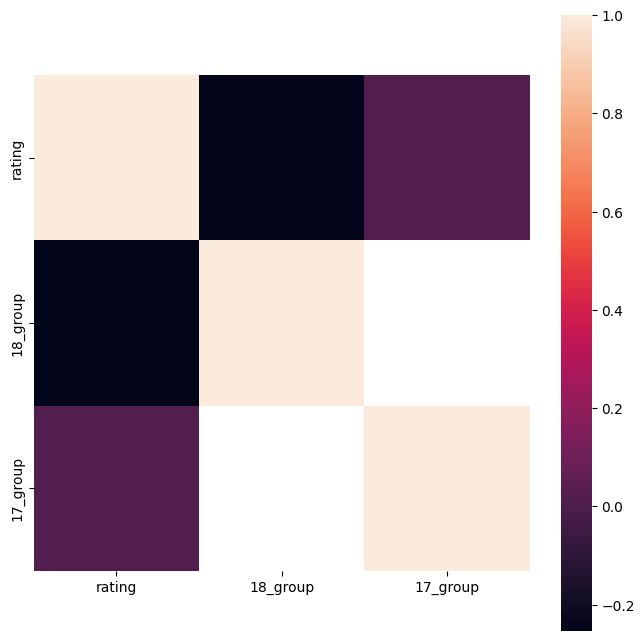

In [54]:
plt.figure(figsize=(8, 8))
sns.heatmap(corrmat, square=True)
plt.show()

К графикам надо относиться серьёзно, они должны быть понятными и информативными. Рассмотрим несколько примеров.

*Прокомментируйте что вам кажется хорошим и плохим на данных графиках.* 

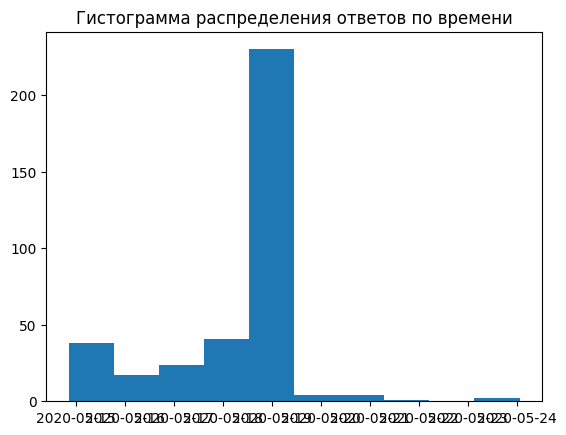

In [55]:
plt.hist(data['timestamp'])
plt.title('Гистограмма распределения ответов по времени')
plt.show()

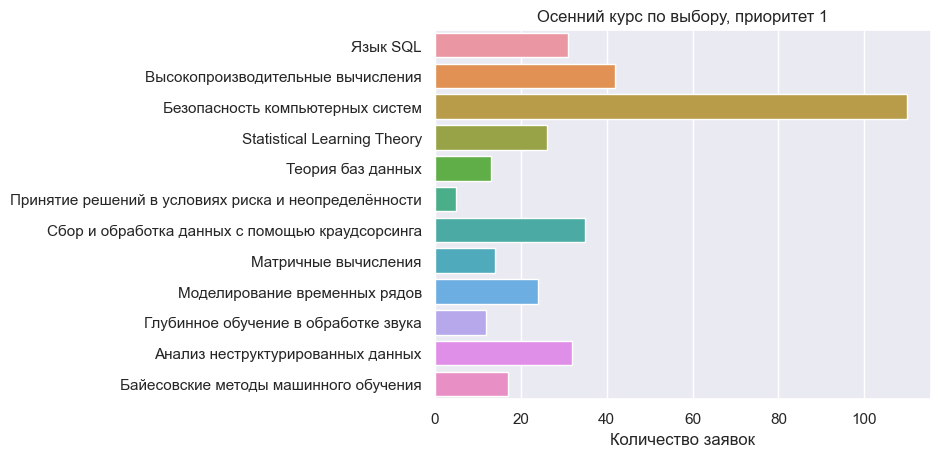

In [56]:
sns.set()

fig, ax = plt.subplots()
ax = sns.countplot(y='fall_1', data=data)
ax.set_title('Осенний курс по выбору, приоритет 1')
ax.set_ylabel('')

ax.set(xlabel='Количество заявок')


plt.show()

In [57]:
crs3 = data[data['17_group'].isna()]
gr_raiting_med = crs3[['18_group', 'rating']].groupby('18_group').median()['rating']
gr_raiting_sum = crs3[['18_group', 'rating']].groupby('18_group').sum()['rating']

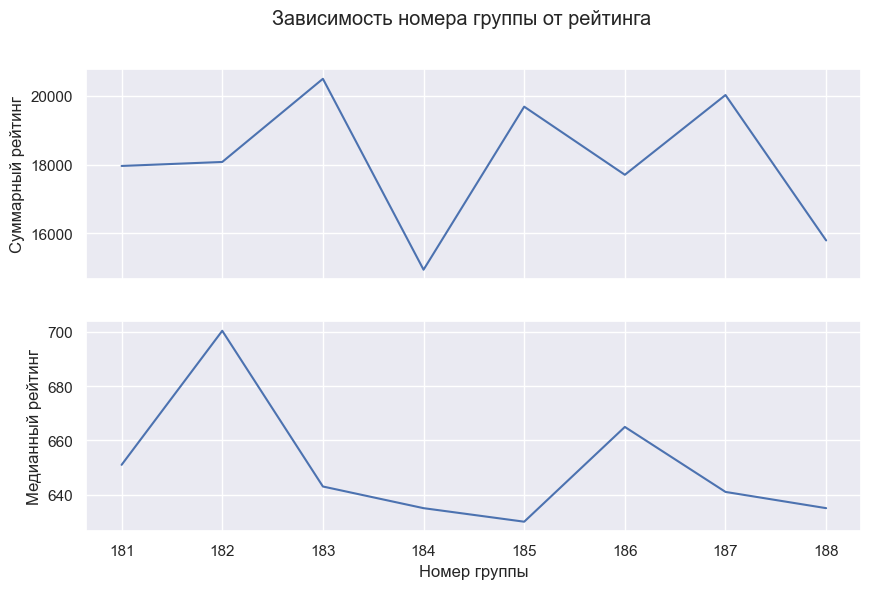

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Зависимость номера группы от рейтинга')
#fig.text('Рейтинг')


axs[0].plot(gr_raiting_sum)
axs[0].set_ylabel('Суммарный рейтинг')

axs[1].plot(gr_raiting_med)
axs[1].set_ylabel('Медианный рейтинг')


plt.xlabel('Номер группы')

plt.show()

Если вы будете делать графики без подписанных осей, с налезающими друг на друга метками, неаккуратными линиями и т.д., то имеете все шансы попасть сюда: https://t.me/funny_homeworks

Сохраним полученную таблицу, чтобы вы могли продолжить с ней работу дома: 

In [59]:
data.to_excel('end_seminar.xlsx', index=False)

### Разведочный анализ данных

Решение любой задачи, связанной с машинным обучением, начинается с разведочного анализа данных. Перед тем, как строить модели, надо понять, сколько у нас данных и какая информация есть о каждом объекте, а также:
* выяснить, нет ли пропусков в данных (т.е. отсутствующих значений признаков у некоторых объектов)
* выяснить, нет ли выбросов (т.е. объектов, которые очень сильно отличаются от большинства, имеют неадекватные значения признаков)
* выяснить, нет ли повторов в данных
* выяснить, нет ли нелогичной информации (например, если мы анализируем данные по кредитам, и видим запись, где кредит выдали пятилетнему ребёнку, то это странно)

И это лишь небольшой список проблем, которые можно выявить. Помимо этого с данными нужно в целом познакомиться, чтобы понять, какие признаки там можно сделать, какие из них будут наиболее полезны.

Попробуем провести такой анализ на реальной задаче предсказания продолжительности поездки на такси в Нью-Йорке: https://www.kaggle.com/c/nyc-taxi-trip-duration/overview

Рассказ во многом взят из ноутбука https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook

In [60]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns

Загрузим данные и изучим доступные нам признаки.

In [61]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

In [62]:
train = pd.read_csv('train.csv')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Смысл столбцов:

* id - идентификатор поездки
* vendor_id - код провайдера, от которого пришла информация о поездке
* pickup_datetime - время старта поездки
* dropoff_datetime - время окончания поездки
* passenger_count - число пассажиров (вводится водителем)
* pickup_longitude - долгота точки посадки
* pickup_latitude - широта точки посадки
* dropoff_longitude - долгота точки высадки
* dropoff_latitude - долгота точки высадки
* store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
* trip_duration - продолжительность поездки в секундах

In [63]:
train.shape

(1458644, 11)

Данных довольно много, поэтому нужно задумываться об эффективности всех вычислений. Ниже мы увидим на примере, что правильное использование возможностей pandas позволит существенно ускорить вычисления.

Посмотрим внимательно на столбцы из нашей таблицы и попробуем проверить, нет ли там противоречий и проблем. Например, в голову приходят следующие вопросы:
* можно ли считать ID уникальным идентификатором поездки, или же есть записи с одинаковыми ID?
* есть ли где-то пропуски?
* действительно ли столбец store_and_fwd_flag принимает только значения Y и N?

In [64]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')

Id is unique.


In [65]:
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] else print('oops')

We do not need to worry about missing values.


In [66]:
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()))))

The store_and_fwd_flag has only two values {'Y', 'N'}.


Посмотрим на типы данных в каждом столбце.

In [67]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Видно, что pandas отнёс столбцы с датами к общему типу object. Будет лучше привести их к типу datetime, чтобы использовать удобные функции для манипуляций с датами. Заодно сделаем проверку — действительно ли столбец check_trip_duration показывает продолжительность поездки, или же он входит в противоречие со столбцами pickup_datetime и dropoff_datetime.

In [68]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [69]:
train.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag              int64
trip_duration                   int64
pickup_date                    object
check_trip_duration           float64
dtype: object

In [70]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016-04-06,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016-03-26,435.0


Ещё имеет смысл проверить целевую переменную trip_duration. Нет ли там выбросов? Какими по продолжительности бывают поездки? Выглядит ли распределение этой переменной осмысленно?

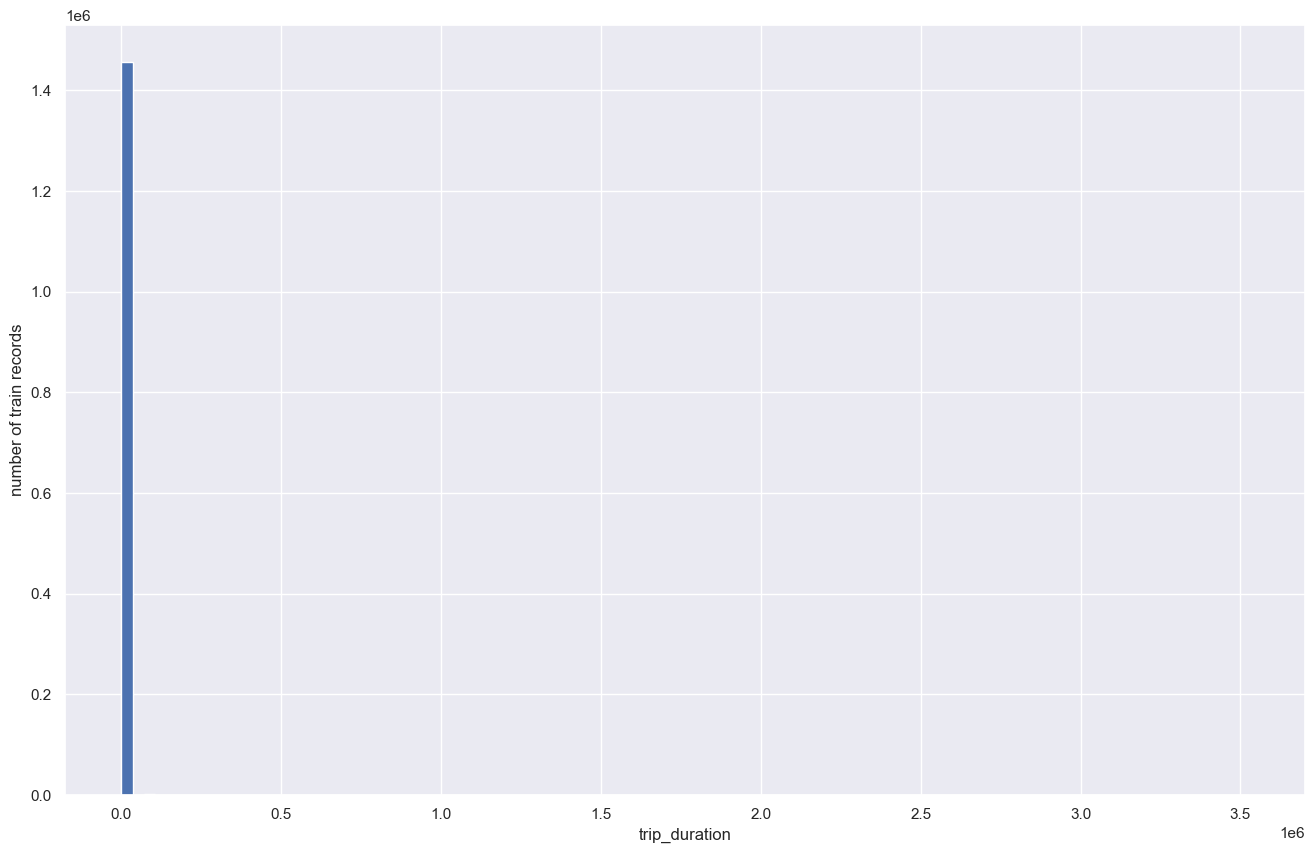

In [71]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

Когда в каком-то столбце распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не очень информативны. В этом случае может быть полезно нарисовать распределение в логарифмической шкале.

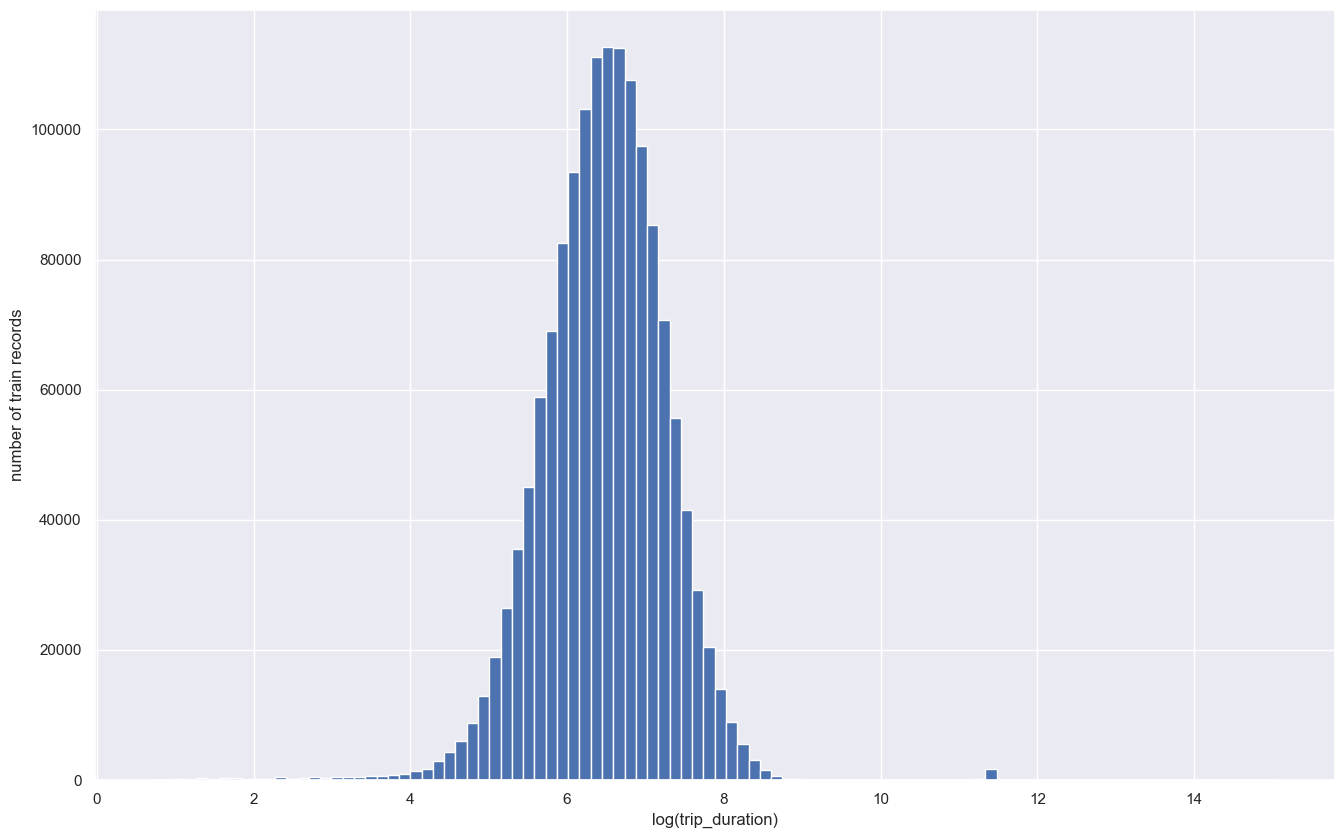

In [72]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

В целом распределение разумное, продолжительность поездки находится примерно в следующем интервале:

In [73]:
print("В секундах:", np.exp(5), np.exp(9))
print("В минутах:", np.exp(5) // 60, np.exp(9) // 60)

В секундах: 148.4131591025766 8103.083927575384
В минутах: 2.0 135.0


Самая длинная поездка (в часах):

In [74]:
train['trip_duration'].max() // 3600

979

In [75]:
train[train.trip_duration >= 979 * 3600]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,0,3526282,2016-02-13,3526282.0,15.075755


Это выброс. Мог сломаться таксометр, водитель мог забыть остановить поездку по каким-то причинам и т.д. В любом случае, будет странно обучаться на таких данных, обычно их выкидывают из выборки. Кандидатов на выбрасывание не так уж много — например, если взять поездки длиной 10 часа и больше, то их окажется около двух тысяч, и определённо надо выяснять, что это такое.

In [76]:
train[train.trip_duration >= 10 * 3600]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,0,84594,2016-02-20,84594.0,11.345630
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,0,86149,2016-05-07,86149.0,11.363845
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,0,86352,2016-06-07,86352.0,11.366199
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,0,86236,2016-02-13,86236.0,11.364855
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,0,85197,2016-03-18,85197.0,11.352733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,0,72504,2016-03-20,72504.0,11.191411
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,0,86233,2016-02-08,86233.0,11.364820
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,0,85311,2016-06-08,85311.0,11.354070
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,0,86314,2016-02-02,86314.0,11.365759


Попробуем нарисовать, откуда обычно стартуют поездки.

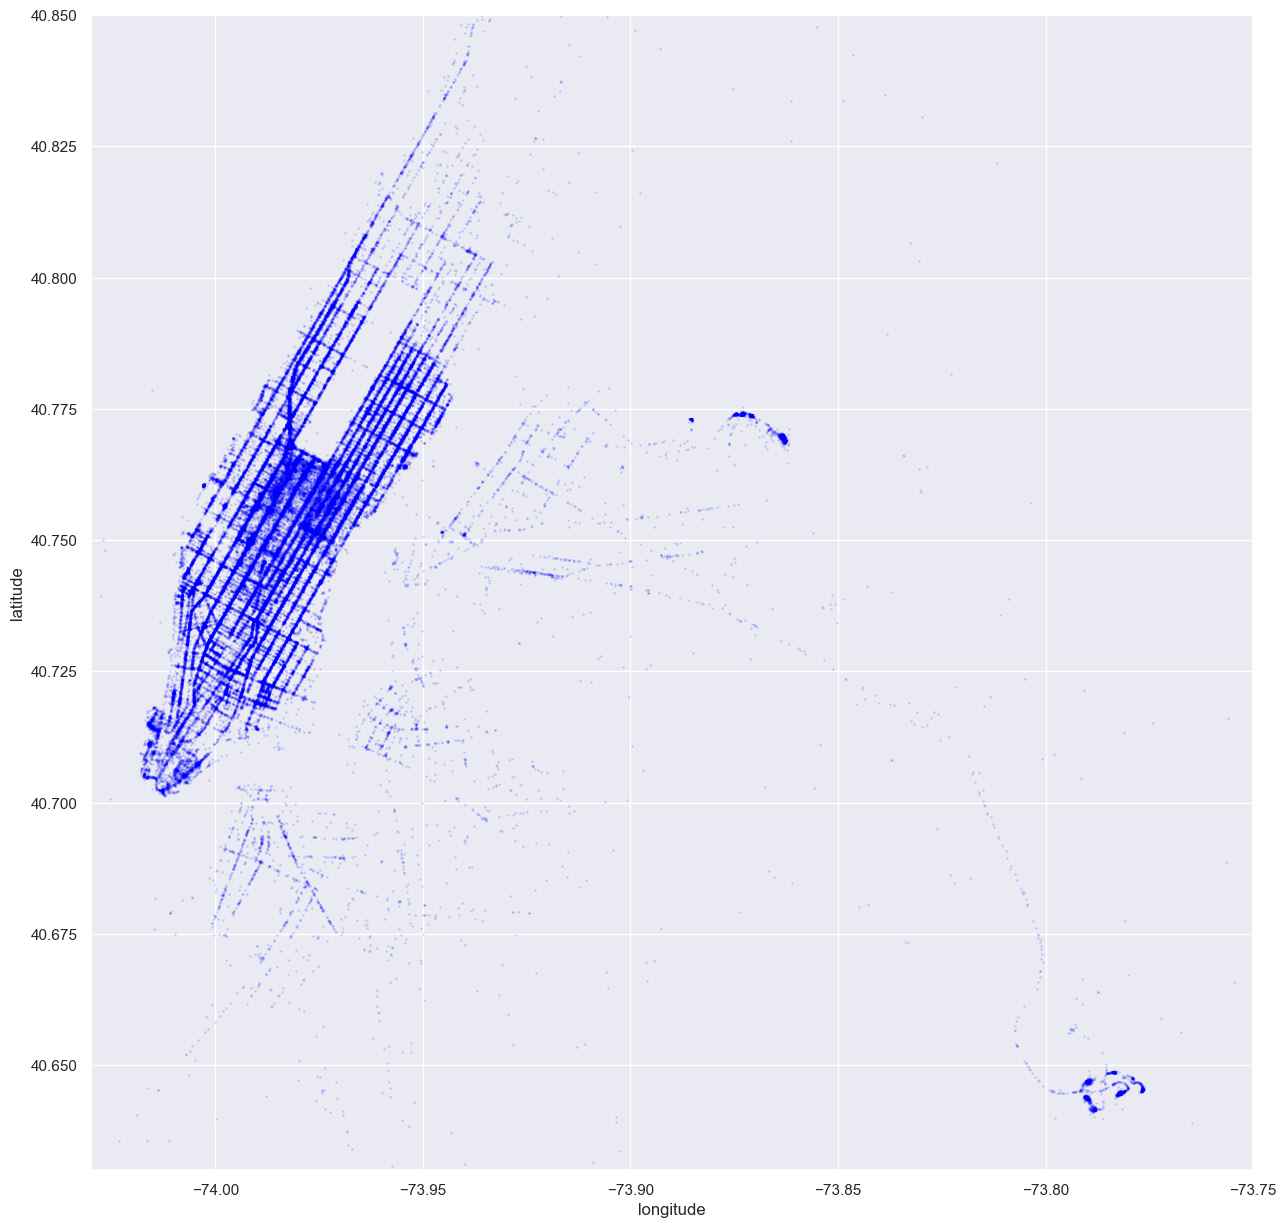

In [77]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Теперь нарисуем как следует, на карте.

In [78]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [79]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [80]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[40.75207462310791, -73.97639054107665], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Кстати, случайный ли порядок записей в таблице? Это важно понимать, например, для разбиения выборки на обучающую и тестовую части. Если порядок не является случайным, а мы отнесём к обучающей части первую половину таблицы, то есть риск, что данные в обучении и тесте будут иметь разные распределения, а значит, модель сможет хорошо работать только на одной из частей.

Text(0, 0.5, 'Дней с момента ранней поездки')

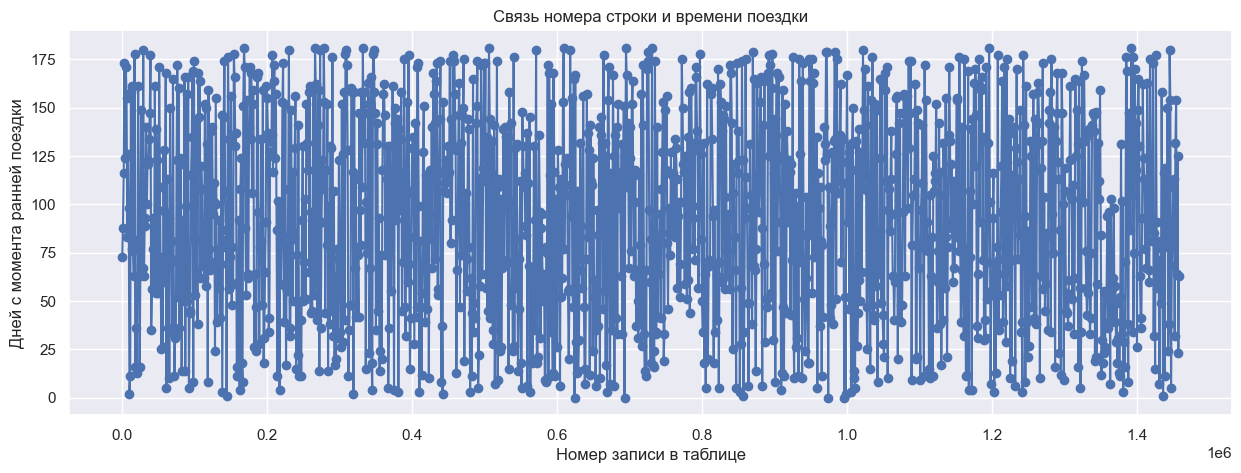

In [81]:
plt.figure(figsize=(15,5))
days_since_min_ride = (train['pickup_datetime'] - train['pickup_datetime'].min()).apply(lambda x: x.total_seconds() // (60*60*24))
plt.plot(days_since_min_ride[::1000], 'o-')
plt.title('Связь номера строки и времени поездки')
plt.xlabel('Номер записи в таблице')
plt.ylabel('Дней с момента ранней поездки')

Вроде бы всё довольно случайно.

Посчитаем какие-нибудь признаки. Скорее всего продолжительность поездки неплохо зависит от расстояния — посчитаем его. Кстати, важно заметить, что само расстояние не может быть признаком, поскольку в тестовой выборке нет информации о пункте назначения. Но мы пока исследуем данные и, может, увидим в расстояниях что-то интересное.

Можно выбрать научный подход и посчитать честное расстояние на сфере между двумя точками. Это называется [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula).

Можно решить, что Земля плоская, и считать стандартные расстояния. В этом случае очень неплохо подойдёт [манхэттенское расстояние](https://en.wikipedia.org/wiki/Taxicab_geometry) — оно учитывает, что машины всё-таки не летают.

In [82]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Обсудим немного скорость вычислений в pandas. Есть несколько способов применить функцию к каждой строке в таблице. Если вы до этого изучали преимущественно C/C++, то первое, что должно прийти вам в голову, — написать цикл.

In [83]:
train1 = train.copy()

In [84]:
%%timeit

for i in range(100):
    train1[i, 'distance_haversine'] = haversine_array(train1['pickup_latitude'].iloc[i], 
                                                      train1['pickup_longitude'].iloc[i], 
                                                      train1['dropoff_latitude'].iloc[i], 
                                                      train1['dropoff_longitude'].iloc[i])

<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

24.5 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Обратите внимание, что мы посчитали расстояния всего лишь для первых 100 записей, и это уже было не очень быстро.

Можно воспользоваться функцией ```apply```.

In [85]:
%%timeit

train1.iloc[:5000, :].apply(lambda x: 
                            haversine_array(x['pickup_latitude'], 
                                            x['pickup_longitude'], 
                                            x['dropoff_latitude'], 
                                            x['dropoff_longitude']),
                            axis=1)

52.9 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


За то же самое время мы успеваем обработать уже 5000 записей, а не 100.

Но лучший способ — это векторизовать вычисления. Подробнее об этом мы будем говорить на следующих семинарах.

In [86]:
%%timeit
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

37.1 ms ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Чуть подробнее об ускорении вычислений можно почитать здесь: https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

Посмотрим на распределения расстояний.

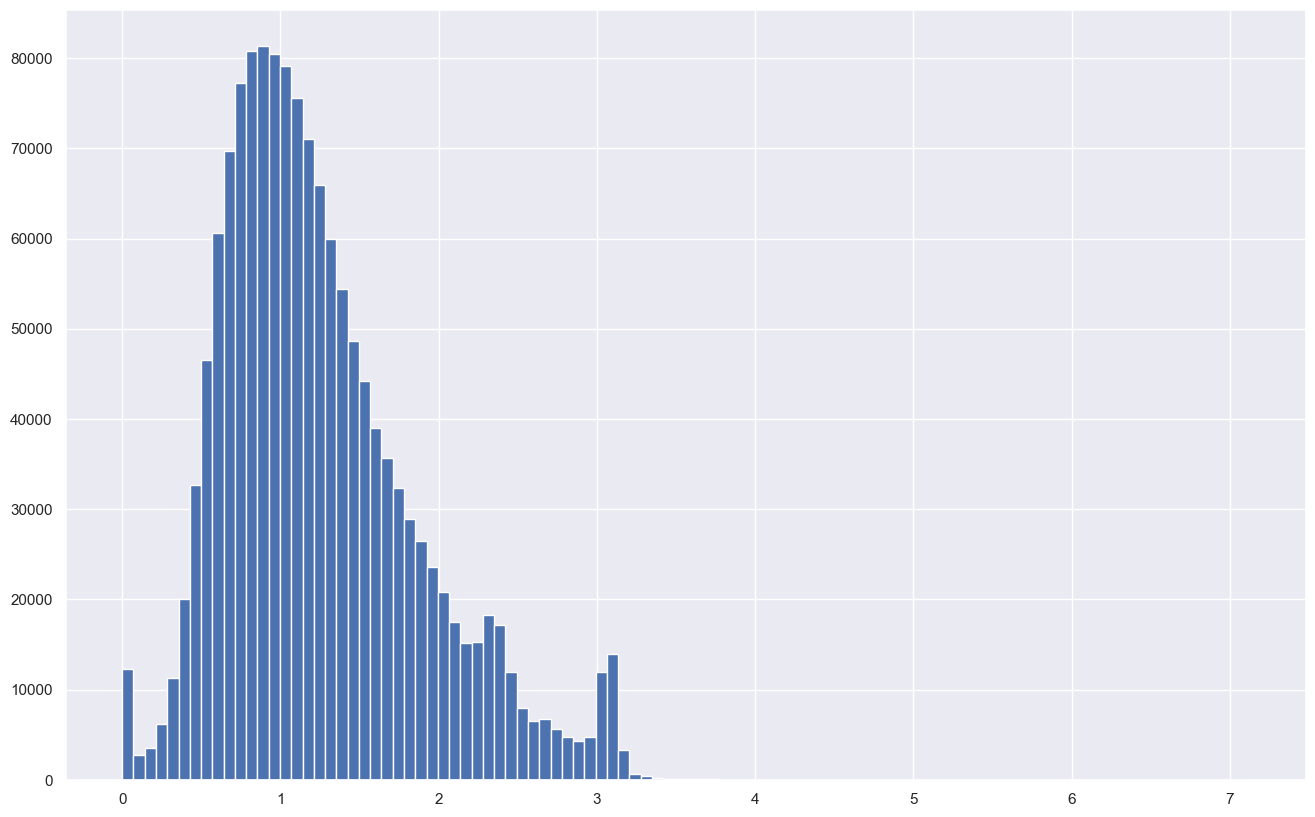

In [87]:
plt.hist(np.log1p(train.distance_haversine), bins=100)
plt.show()

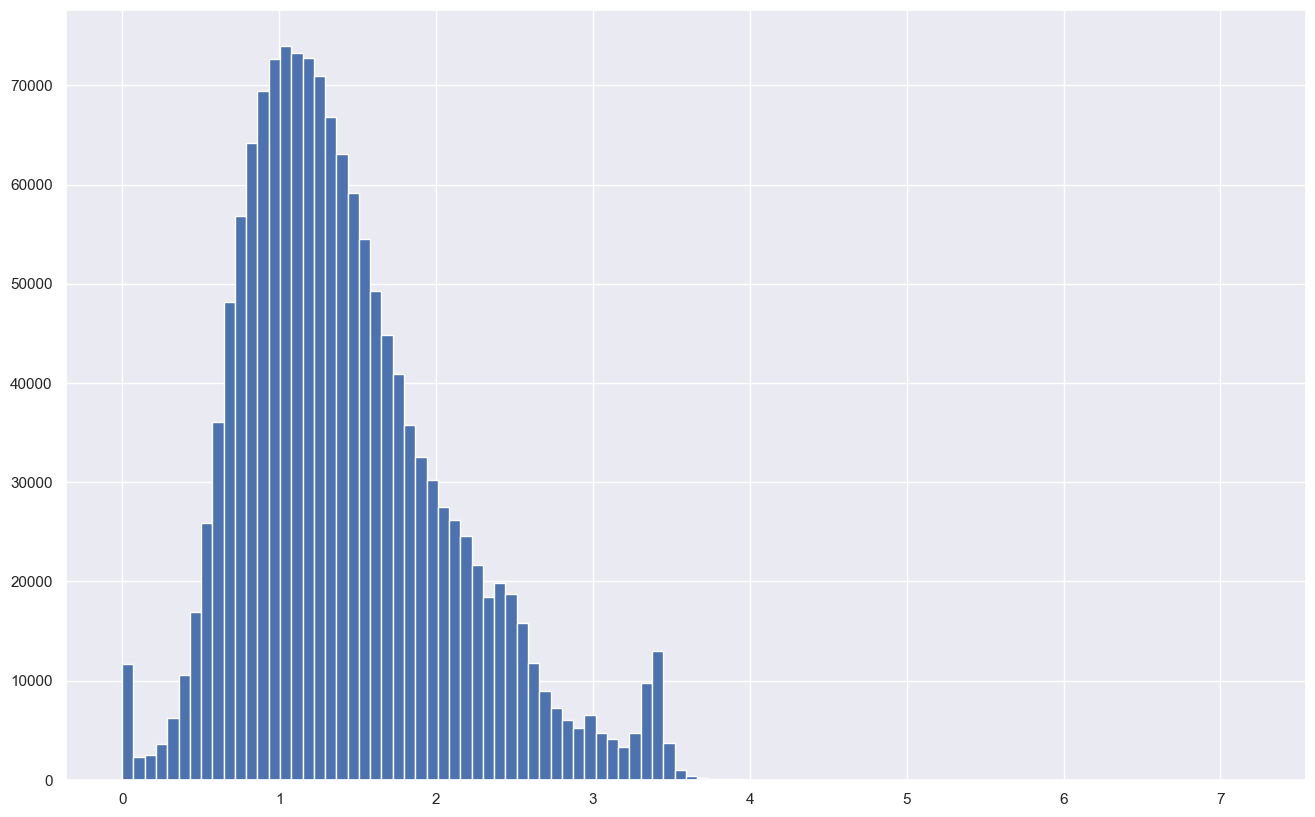

In [88]:
plt.hist(np.log1p(train.distance_dummy_manhattan), bins=100)
plt.show()

Выглядят достаточно одинаково.

Поисследуем теперь связь между расстоянием и продолжительностью поездки.

Text(0, 0.5, 'trip duration')

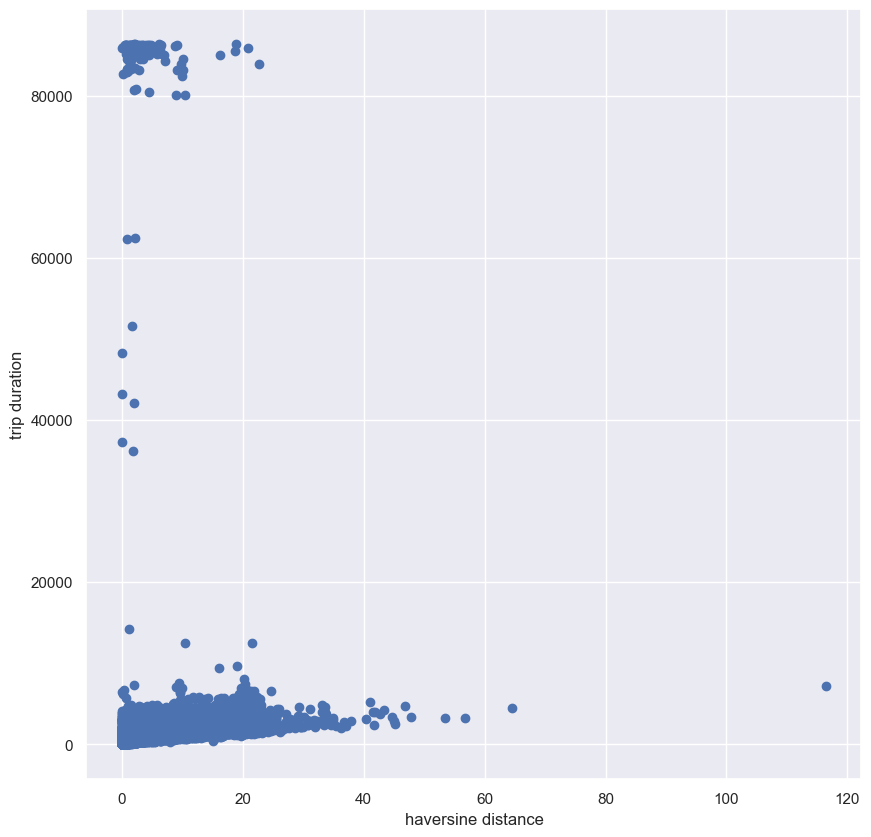

In [89]:
plt.figure(figsize=(10,10))
plt.scatter(train.distance_haversine[:100000], train.trip_duration[:100000], marker='o')
plt.xlabel('haversine distance')
plt.ylabel('trip duration')

В нижней части графика точки неплохо выстраиваются в линию, но ещё есть некоторое количество выбросов. Нарисуем тот же график без них.

Text(0, 0.5, 'trip duration')

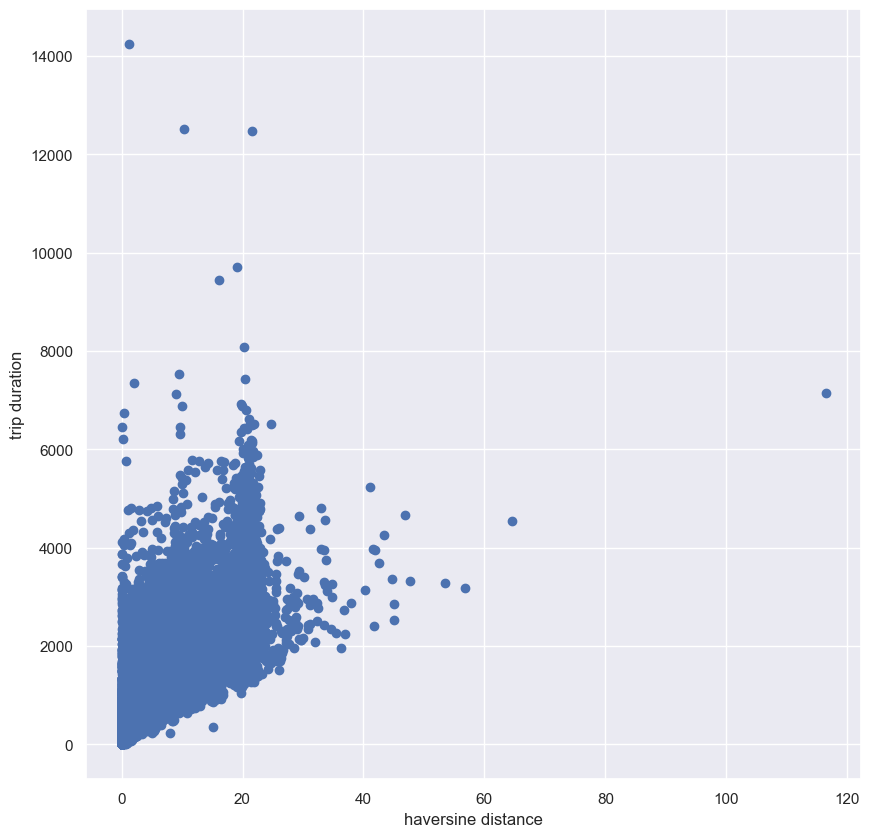

In [90]:
plt.figure(figsize=(10,10))
plt.scatter(train[train.trip_duration < 20000].distance_haversine[:100000],
            train[train.trip_duration < 20000].trip_duration[:100000], marker='o')
plt.xlabel('haversine distance')
plt.ylabel('trip duration')

Кажется, тут вполне может сработать линейная регрессия!

Ещё раз напомним, что расстояние не может быть признаком, его не посчитать для тестовой выборки. Но мы пока просто играемся.

In [91]:
from sklearn import linear_model, metrics

In [92]:
train_filtered = train[train.trip_duration < 20000]
X = train_filtered.distance_haversine.values[:, np.newaxis]
y = train_filtered.trip_duration.values

regr = linear_model.Ridge()
regr.fit(X, y)
metrics.mean_absolute_error(regr.predict(X), y)

299.659218033977

In [93]:
train_filtered = train[train.trip_duration < 20000]
X = train_filtered.distance_dummy_manhattan.values[:, np.newaxis]
y = train_filtered.trip_duration.values

regr = linear_model.Ridge()
regr.fit(X, y)
metrics.mean_absolute_error(regr.predict(X), y)

306.0326596057506

То есть в среднем модель ошибается где-то на 300 секунд при предсказании продолжительности поездки. Как понять, хорошо это или плохо? Например, сравнить с качеством константной модели — например, которая всегда в качестве прогноза выдаёт медианное или среднее время поездки.

In [94]:
metrics.mean_absolute_error(np.median(y) * np.ones(y.shape), y)

444.8109724449668

In [95]:
metrics.mean_absolute_error(np.mean(y) * np.ones(y.shape), y)

468.0349997665766

### Почему важно исследовать данные?

Иногда бывает, что задача сложная, но при этом хорошего качества можно добиться с помощью простых правил. Причины могут быть разные:
* Разметка собрана по простому правилу. Например, для задачи предсказания тональности твитов могли сделать разметку через эмодзи — тогда достаточно, скажем, добавить признак "наличие в тексте подстроки ':)'".
* Задача действительно простая и не требует поиска закономерностей методами машинного обучения.
* В данных есть утечка (leak) — то есть в признаках содержится информация, которая на самом деле не должна быть доступна при построении прогноза.

Про некоторые истории с утечками можно почитать и посмотреть здесь:
* https://dyakonov.org/2018/06/28/простые-методы-анализа-данных/
* https://www.kaggle.com/c/the-icml-2013-whale-challenge-right-whale-redux/discussion/4865
* https://www.youtube.com/watch?v=UOxf2P9WnK8